# AI vs Human dataset: evaluation and cleaning

Inspect `merged_ai_human_multisocial_features.csv`, surface data quality issues, and export a cleaned file ready for modeling.

## Goals
- Load the merged feature set and review its shape, schema, and label balance.
- Check for missing values, duplicates, constant columns, and obvious outliers.
- Visualize key feature distributions on a manageable sample.
- Apply lightweight cleaning (strip text, drop duplicate texts, drop constant columns, clip numeric outliers).
- Save a cleaned CSV next to the source file.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 200)
sns.set_theme(style="whitegrid")

DATA_PATH = Path("merged_ai_human_multisocial_features.csv")
OUTPUT_PATH = DATA_PATH.with_name(DATA_PATH.stem + "_cleaned.csv")
SAMPLE_SEED = 42
SAMPLE_SIZE = 5000

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATA_PATH}")


In [2]:
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df):,} rows and {df.shape[1]} columns from {DATA_PATH.name}")
df.head()


Loaded 928,709 rows and 53 columns from merged_ai_human_multisocial_features.csv


,text,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,length,potential_noise,lang_ar,lang_ca,lang_de,lang_en,lang_es,lang_hr,lang_nl,lang_other,lang_pl,lang_pt,lang_ro,lang_ru,lang_unknown,src_ai_human,src_discord,src_gab,src_multisocial_discord,src_multisocial_gab,src_multisocial_telegram,src_multisocial_twitter,src_multisocial_whatsapp,src_telegram,src_twitter,src_whatsapp,model_Mistral-7B-Instruct-v0.2,model_aya-101,model_gemini,model_gpt-3.5-turbo-0125,model_human,model_opt-iml-max-30b,model_unknown_model,model_v5-Eagle-7B-HF,model_vicuna-13b,ds_ai_human,ds_multisocial,label
0,"Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, peo...",588.0,3286.0,24.0,0.464286,24.500000,4.469388,0.022824,58.943306,13.375700,0.0,0.208333,0.535714,0.569061,0.9643,3286,0,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0
1,"Transportation is a large necessity in most countries worldwide. With no doubt, cars, buses, and other means of transportation make going from place to place easier and faster. However there's alw...",465.0,2734.0,27.0,0.505376,17.222222,4.750538,0.023409,59.271118,11.606349,0.0,0.296296,0.494624,0.385476,-0.2426,2734,0,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0
2,"""America's love affair with it's vehicles seems to be cooling"" says Elisabeth rosenthal. To understand rosenthal's perspective, it is easier to suggest that America's car usage is decreasing slowl...",750.0,4424.0,48.0,0.428000,15.625000,4.773333,0.022830,52.957191,12.652336,0.0,0.145833,0.572000,0.373646,0.9909,4424,0,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0
3,How often do you ride in a car? Do you drive a one or any other motor vehicle to work? The store? To the mall? Have you ever thought about how many people in the world do that exact same thing tra...,699.0,4011.0,51.0,0.494993,13.705882,4.580830,0.030915,61.901968,10.148105,0.0,0.078431,0.505007,0.540033,0.9902,4011,0,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0
4,Cars are a wonderful thing. They are perhaps one of the worlds greatest advancements and technologies. Cars get us from point a to point i. That is exactly what we want isnt it? We as humans want ...,867.0,4695.0,51.0,0.370242,17.000000,4.284890,0.023429,69.131164,10.704695,0.0,0.039216,0.629758,0.508583,-0.9005,4695,0,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0


### Dataset overview

In [3]:
overview = {
    "rows": len(df),
    "columns": df.shape[1],
    "memory_mb": round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2),
    "text_length_mean": float(df["text"].str.len().mean()),
    "text_length_median": float(df["text"].str.len().median()),
}

display(pd.Series(overview, name="overview"))
print("\nColumn dtypes:")
display(df.dtypes)


rows                  928709.00000
columns                   53.00000
memory_mb               1371.84000
text_length_mean        1205.16975
text_length_median       871.00000
Name: overview, dtype: float64


Column dtypes:


text                               object
word_count                        float64
character_count                   float64
sentence_count                    float64
lexical_diversity                 float64
avg_sentence_length               float64
avg_word_length                   float64
punctuation_ratio                 float64
flesch_reading_ease               float64
gunning_fog_index                 float64
grammar_errors                    float64
passive_voice_ratio               float64
predictability_score              float64
burstiness                        float64
sentiment_score                   float64
length                              int64
potential_noise                     int64
lang_ar                              bool
lang_ca                              bool
lang_de                              bool
lang_en                              bool
lang_es                              bool
lang_hr                              bool
lang_nl                           

,label,count,share
0,0,342253,0.368526
1,1,586456,0.631474


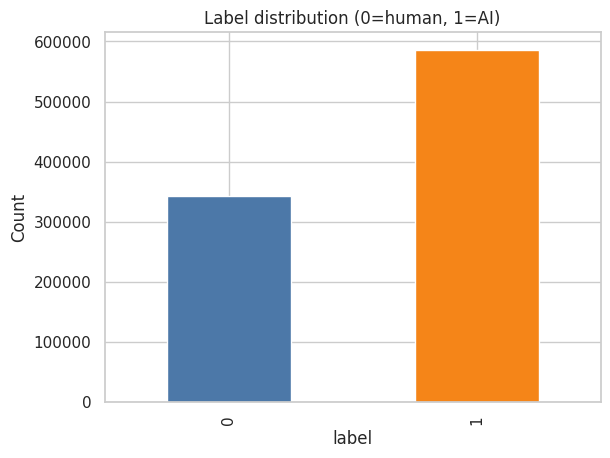

In [4]:
label_counts = df["label"].value_counts().sort_index()
label_df = pd.DataFrame(
    {
        "label": label_counts.index,
        "count": label_counts.values,
        "share": label_counts.values / len(df),
    }
)

display(label_df)

ax = label_counts.plot(kind="bar", color=["#4C78A8", "#F58518"])
ax.set_ylabel("Count")
ax.set_title("Label distribution (0=human, 1=AI)")
plt.show()


In [5]:
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:")
display(missing if not missing.empty else pd.Series(dtype=int))

dup_rows = df.duplicated().sum()
dup_text = df["text"].duplicated().sum()
print(f"Duplicate rows: {dup_rows:,}")
print(f"Duplicate texts: {dup_text:,}")


Columns with missing values:


Series([], dtype: int64)

Duplicate rows: 0
Duplicate texts: 24


In [6]:
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) == 1]
print(f"Constant columns: {constant_cols if constant_cols else 'None'}")


Constant columns: ['potential_noise']


In [7]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
numeric_stats = df[numeric_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
numeric_stats = numeric_stats[["min", "1%", "5%", "50%", "95%", "99%", "max"]]
numeric_stats


,min,1%,5%,50%,95%,99%,max
word_count,0.0000,3.000000,4.000000,155.000000,624.000000,873.000000,1680.000000
character_count,1.0000,14.000000,24.000000,871.000000,3564.000000,4997.000000,16094.000000
sentence_count,1.0000,1.000000,1.000000,8.000000,32.000000,44.000000,276.000000
lexical_diversity,0.0000,0.277174,0.339067,0.633929,1.000000,1.000000,1.000000
avg_sentence_length,0.0000,2.000000,3.500000,15.000000,27.900000,43.000000,754.000000
avg_word_length,0.0000,2.750000,3.600000,4.622699,6.358974,8.357143,617.846154
punctuation_ratio,0.0000,0.000000,0.008811,0.023796,0.100000,0.176471,1.000000
flesch_reading_ease,-5463.3950,-15.774932,22.624812,63.095625,114.622500,119.190000,147.390000
gunning_fog_index,0.0000,1.200000,1.600000,10.816049,18.558730,24.222222,293.220908
grammar_errors,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000


### Anomaly checks
Quick sanity checks to spot structurally broken rows before cleaning.

In [8]:
length_diff = (df["length"] - df["character_count"]).abs()
anomaly_counts = {
    "length_vs_char_mismatch": int((length_diff > 0).sum()),
    "word_count_zero": int((df["word_count"] <= 0).sum()),
    "avg_word_length_gt_20": int((df["avg_word_length"] > 20).sum()),
    "avg_sentence_length_gt_200": int((df["avg_sentence_length"] > 200).sum()),
    "gunning_fog_index_gt_60": int((df["gunning_fog_index"] > 60).sum()),
    "flesch_reading_ease_lt_-100": int((df["flesch_reading_ease"] < -100).sum()),
}

print("Potential anomalies by rule:")
display(pd.Series(anomaly_counts, name="anomaly_counts"))


Potential anomalies by rule:


length_vs_char_mismatch           0
word_count_zero                 101
avg_word_length_gt_20           404
avg_sentence_length_gt_200      355
gunning_fog_index_gt_60         587
flesch_reading_ease_lt_-100    2164
Name: anomaly_counts, dtype: int64

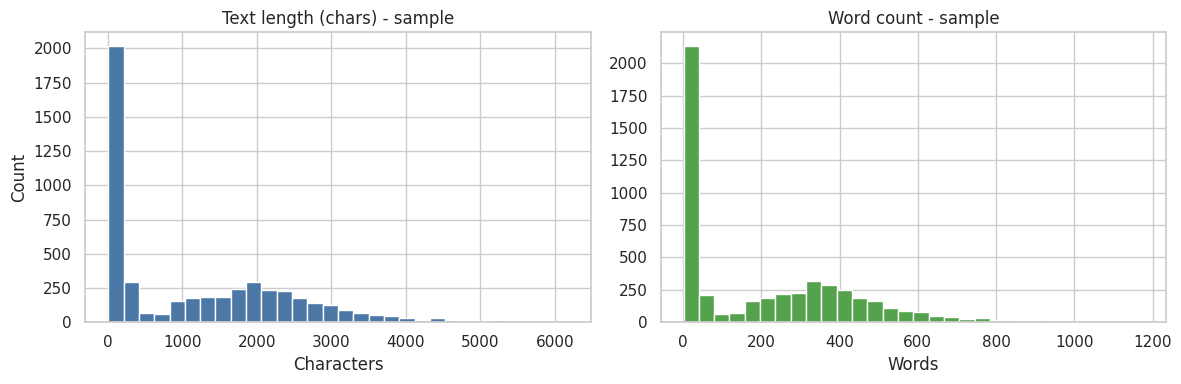

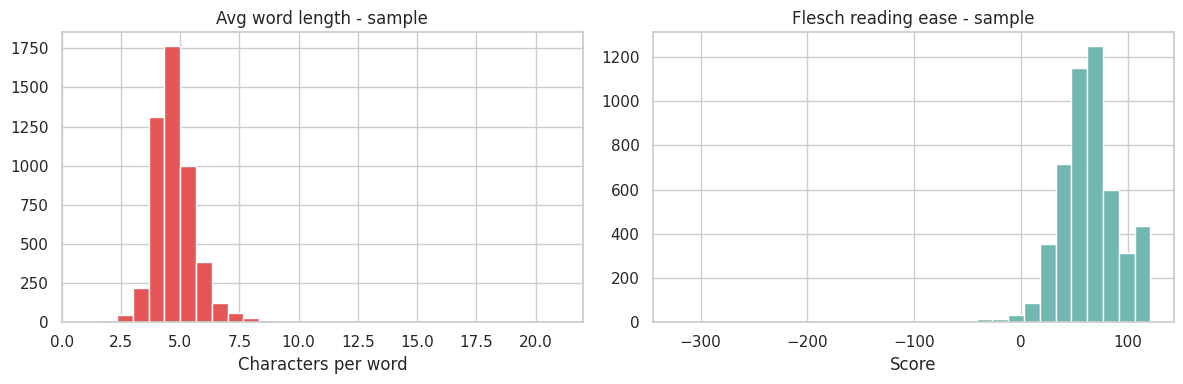

In [9]:
sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=SAMPLE_SEED)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(sample["text"].str.len(), bins=30, color="#4C78A8")
axes[0].set_title("Text length (chars) - sample")
axes[0].set_xlabel("Characters")
axes[0].set_ylabel("Count")

axes[1].hist(sample["word_count"], bins=30, color="#54A24B")
axes[1].set_title("Word count - sample")
axes[1].set_xlabel("Words")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(sample["avg_word_length"], bins=30, color="#E45756")
axes[0].set_title("Avg word length - sample")
axes[0].set_xlabel("Characters per word")

axes[1].hist(sample["flesch_reading_ease"], bins=30, color="#72B7B2")
axes[1].set_title("Flesch reading ease - sample")
axes[1].set_xlabel("Score")

plt.tight_layout()
plt.show()


In [10]:
def summarize_one_hot(prefix: str):
    cols = [c for c in df.columns if c.startswith(prefix)]
    counts = df[cols].sum().sort_values(ascending=False)
    return counts.to_frame(name="count")

lang_counts = summarize_one_hot("lang_")
src_counts = summarize_one_hot("src_")
model_counts = summarize_one_hot("model_")

print("Language flags:")
display(lang_counts)
print("\nSource flags:")
display(src_counts)
print("\nModel flags:")
display(model_counts)


Language flags:


,count
lang_unknown,464704
lang_other,115185
lang_es,49799
lang_en,48230
lang_pt,43904
lang_nl,40018
lang_de,30527
lang_ru,24030
lang_ro,23933
lang_pl,23644



Source flags:


,count
src_ai_human,464704
src_multisocial_telegram,153336
src_multisocial_discord,94086
src_multisocial_gab,69632
src_multisocial_twitter,63407
src_multisocial_whatsapp,26211
src_telegram,22772
src_discord,11093
src_gab,10168
src_twitter,9370



Model flags:


,count
model_human,342253
model_unknown_model,179784
model_Mistral-7B-Instruct-v0.2,60352
model_vicuna-13b,59801
model_gemini,58780
model_v5-Eagle-7B-HF,58725
model_gpt-3.5-turbo-0125,57822
model_aya-101,56923
model_opt-iml-max-30b,54269


### Cleaning steps
Rules baked into the helpers below:
- Strip whitespace from text and drop rows where text becomes empty.
- Drop duplicate texts (keep first occurrence).
- Drop constant-value feature columns.
- Clip numeric features to the [1st, 99th] percentiles to blunt extreme outliers.
- Optionally drop structurally broken rows (zero words, extreme readability/length metrics).
Adjust thresholds as needed for downstream modeling.

In [11]:
def clean_dataset(frame: pd.DataFrame, text_col: str = "text", min_chars: int = 1, clip_quantiles=(0.01, 0.99)):
    rows_start = len(frame)
    df_clean = frame.copy()

    df_clean[text_col] = df_clean[text_col].astype(str).str.strip()
    df_clean = df_clean[df_clean[text_col].str.len() >= min_chars]
    rows_after_strip = len(df_clean)

    df_clean = df_clean.drop_duplicates(subset=[text_col])
    rows_after_dedup = len(df_clean)

    dropped_constant = [c for c in df_clean.columns if c != "label" and df_clean[c].nunique(dropna=False) == 1]
    if dropped_constant:
        df_clean = df_clean.drop(columns=dropped_constant)

    numeric_cols = [c for c in df_clean.select_dtypes(include=["float64", "int64"]).columns if c != "label"]
    lower_q, upper_q = clip_quantiles
    quantiles = df_clean[numeric_cols].quantile([lower_q, upper_q])
    for col in numeric_cols:
        low, high = quantiles.loc[lower_q, col], quantiles.loc[upper_q, col]
        df_clean[col] = df_clean[col].clip(lower=low, upper=high)

    summary = {
        "rows_start": rows_start,
        "rows_after_strip": rows_after_strip,
        "rows_after_dedup": rows_after_dedup,
        "duplicates_removed": rows_after_strip - rows_after_dedup,
        "dropped_constant_cols": dropped_constant,
        "clip_bounds": {col: (float(quantiles.loc[lower_q, col]), float(quantiles.loc[upper_q, col])) for col in numeric_cols},
    }
    return df_clean, summary


In [12]:
def apply_anomaly_filters(frame: pd.DataFrame):
    """Drop rows that violate simple structural sanity rules."""
    rules = {
        "word_count_gt_0": frame["word_count"] > 0,
        "avg_word_length_le_20": frame["avg_word_length"] <= 20,
        "avg_sentence_length_le_200": frame["avg_sentence_length"] <= 200,
        "gunning_fog_index_le_60": frame["gunning_fog_index"] <= 60,
        "flesch_reading_ease_ge_-100": frame["flesch_reading_ease"] >= -100,
    }
    mask = pd.Series(True, index=frame.index)
    dropped_by_rule = {}
    for name, cond in rules.items():
        dropped_by_rule[name] = int((~cond).sum())
        mask &= cond
    filtered = frame[mask].copy()
    report = {
        "rows_start": len(frame),
        "rows_after_filters": len(filtered),
        "total_dropped": int((~mask).sum()),
        "dropped_by_rule": dropped_by_rule,
    }
    return filtered, report


In [13]:
filtered_df, anomaly_report = apply_anomaly_filters(df)
print("Anomaly filter summary:")
print(anomaly_report)

cleaned_df, cleaning_report = clean_dataset(filtered_df, min_chars=1, clip_quantiles=(0.01, 0.99))

print("Cleaning summary:")
for key, value in cleaning_report.items():
    if key == "clip_bounds":
        preview = {k: v for i, (k, v) in enumerate(value.items()) if i < 5}
        print(f"{key} (first 5 features): {preview}")
    else:
        print(f"{key}: {value}")

print(f"\nRows change: {len(df):,} -> {len(filtered_df):,} -> {len(cleaned_df):,}")
print(f"Columns change: {df.shape[1]} -> {cleaned_df.shape[1]}")

print("\nLabel distribution after cleaning:")
print(cleaned_df["label"].value_counts())
cleaned_df.head()


Anomaly filter summary:
{'rows_start': 928709, 'rows_after_filters': 925867, 'total_dropped': 2842, 'dropped_by_rule': {'word_count_gt_0': 101, 'avg_word_length_le_20': 404, 'avg_sentence_length_le_200': 355, 'gunning_fog_index_le_60': 587, 'flesch_reading_ease_ge_-100': 2164}}


Cleaning summary:
rows_start: 925867
rows_after_strip: 925867
rows_after_dedup: 925843
duplicates_removed: 24
dropped_constant_cols: ['potential_noise']
clip_bounds (first 5 features): {'word_count': (3.0, 873.0), 'character_count': (14.0, 4998.0), 'sentence_count': (1.0, 44.0), 'lexical_diversity': (0.2777777777777778, 1.0), 'avg_sentence_length': (2.0, 42.04441904761873)}

Rows change: 928,709 -> 925,867 -> 925,843
Columns change: 53 -> 52

Label distribution after cleaning:
label
1    585003
0    340840
Name: count, dtype: int64


,text,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,length,lang_ar,lang_ca,lang_de,lang_en,lang_es,lang_hr,lang_nl,lang_other,lang_pl,lang_pt,lang_ro,lang_ru,lang_unknown,src_ai_human,src_discord,src_gab,src_multisocial_discord,src_multisocial_gab,src_multisocial_telegram,src_multisocial_twitter,src_multisocial_whatsapp,src_telegram,src_twitter,src_whatsapp,model_Mistral-7B-Instruct-v0.2,model_aya-101,model_gemini,model_gpt-3.5-turbo-0125,model_human,model_opt-iml-max-30b,model_unknown_model,model_v5-Eagle-7B-HF,model_vicuna-13b,ds_ai_human,ds_multisocial,label
0,"Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, peo...",588.0,3286.0,24.0,0.464286,24.500000,4.469388,0.022824,58.943306,13.375700,0.0,0.208333,0.535714,0.569061,0.9643,3286,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0
1,"Transportation is a large necessity in most countries worldwide. With no doubt, cars, buses, and other means of transportation make going from place to place easier and faster. However there's alw...",465.0,2734.0,27.0,0.505376,17.222222,4.750538,0.023409,59.271118,11.606349,0.0,0.296296,0.494624,0.385476,-0.2426,2734,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0
2,"""America's love affair with it's vehicles seems to be cooling"" says Elisabeth rosenthal. To understand rosenthal's perspective, it is easier to suggest that America's car usage is decreasing slowl...",750.0,4424.0,44.0,0.428000,15.625000,4.773333,0.022830,52.957191,12.652336,0.0,0.145833,0.572000,0.373646,0.9909,4424,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0
3,How often do you ride in a car? Do you drive a one or any other motor vehicle to work? The store? To the mall? Have you ever thought about how many people in the world do that exact same thing tra...,699.0,4011.0,44.0,0.494993,13.705882,4.580830,0.030915,61.901968,10.148105,0.0,0.078431,0.505007,0.540033,0.9902,4011,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0
4,Cars are a wonderful thing. They are perhaps one of the worlds greatest advancements and technologies. Cars get us from point a to point i. That is exactly what we want isnt it? We as humans want ...,867.0,4695.0,44.0,0.370242,17.000000,4.284890,0.023429,69.131164,10.704695,0.0,0.039216,0.629758,0.508583,-0.9005,4695,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,0


In [14]:
cleaned_df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved cleaned dataset to {OUTPUT_PATH} ({len(cleaned_df):,} rows, {cleaned_df.shape[1]} columns)")
if OUTPUT_PATH.exists():
    size_mb = OUTPUT_PATH.stat().st_size / 1024 ** 2
    print(f"File size: {size_mb:.2f} MB")


Saved cleaned dataset to merged_ai_human_multisocial_features_cleaned.csv (925,843 rows, 52 columns)
File size: 1405.53 MB
